In [1]:
!pip install pandas
!pip install numpy
!pip install osmnx
!pip install matplotlib
!pip install scikit-learn
!pip install pathlib
!pip install gymnasium
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 253.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 237.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 21.9 MB/s eta 0:00:00


In [2]:

import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
import math
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
from gymnasium import spaces
from sklearn.neighbors import KDTree

In [3]:
eved_folder = "./eVED"

def load_csv_files(folder_path, chunk_size=100000):
    folder_path = Path(folder_path)
    csv_files = list(folder_path.glob('*.csv'))
    print(f"Found {len(csv_files)} CSV files")

    for file in csv_files:
        print(f"  - {file.name} ({file.stat().st_size / (1024*1024):.2f} MB)")

    dataframes = []
    for file in csv_files:
        try:
            file_size_mb = file.stat().st_size / (1024*1024)

            if file_size_mb > 500:
                print(f"Loading {file.name} in chunks...")

                chunks = pd.read_csv(file, chunksize=chunk_size, low_memory=False)
                df_chunks = []
                for chunk in chunks:

                    df_chunks.append(chunk)
                df = pd.concat(df_chunks, ignore_index=True)
            else:
                df = pd.read_csv(file, low_memory=False)

            df['source_file'] = file.name
            dataframes.append(df)
            print(f"Successfully loaded {file.name}")

        except Exception as e:
            print(f"Error loading {file}: {e}")

    if not dataframes:
        print("No files were successfully loaded")
        return pd.DataFrame()

    return pd.concat(dataframes, ignore_index=True)

ev_df = load_csv_files(eved_folder)
print(f"Total rows in combined dataset: {len(ev_df)}")
print(f"Columns: {ev_df.columns.tolist()}")
ev_df.head()

Found 54 CSV files
  - eVED_180207_week.csv (5.00 MB)
  - eVED_180110_week.csv (4.00 MB)
  - eVED_180124_week.csv (4.00 MB)
  - eVED_180117_week.csv (4.00 MB)
  - eVED_171227_week.csv (4.00 MB)
  - eVED_171220_week.csv (4.00 MB)
  - eVED_180103_week.csv (4.00 MB)
  - eVED_171213_week.csv (4.00 MB)
  - eVED_171129_week.csv (4.00 MB)
  - eVED_171206_week.csv (4.00 MB)
  - eVED_171122_week.csv (4.00 MB)
  - eVED_171101_week.csv (4.00 MB)
  - eVED_171115_week.csv (4.00 MB)
  - eVED_171108_week.csv (4.00 MB)
  - eVED_181017_week.csv (4.00 MB)
  - eVED_181031_week.csv (4.00 MB)
  - eVED_181107_week.csv (3.00 MB)
  - eVED_181010_week.csv (4.00 MB)
  - eVED_181024_week.csv (3.00 MB)
  - eVED_181003_week.csv (3.00 MB)
  - eVED_180822_week.csv (3.00 MB)
  - eVED_180912_week.csv (3.00 MB)
  - eVED_180815_week.csv (3.00 MB)
  - eVED_180905_week.csv (3.00 MB)
  - eVED_180926_week.csv (3.00 MB)
  - eVED_180919_week.csv (3.00 MB)
  - eVED_180829_week.csv (3.00 MB)
  - eVED_180718_week.csv (3.00 MB)
 

,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],...,Matched Longitude[deg],Match Type,Class of Speed Limit,Speed Limit[km/h],Speed Limit with Direction[km/h],Intersection,Bus Stops,Focus Points,source_file,Focus Points;
0,99.866567,5.0,1760.0,0.0,42.271852,-83.741796,31.0,6.87,1491.0,25.09804,...,-83.741771,0.0,0.0,40,40.0,NaN,NaN,NaN,eVED_180207_week.csv,NaN
1,99.866567,5.0,1760.0,800.0,42.271852,-83.741796,25.0,6.87,1491.0,25.09804,...,-83.741771,1.0,0.0,40,40.0,NaN,NaN,NaN,eVED_180207_week.csv,NaN
2,99.866567,5.0,1760.0,1200.0,42.271852,-83.741796,25.0,7.15,1502.0,25.09804,...,-83.741771,1.0,0.0,40,40.0,NaN,NaN,NaN,eVED_180207_week.csv,NaN
3,99.866567,5.0,1760.0,1800.0,42.271852,-83.741796,13.0,7.15,1502.0,25.09804,...,-83.741771,1.0,0.0,40,40.0,NaN,NaN,NaN,eVED_180207_week.csv,NaN
4,99.866567,5.0,1760.0,2800.0,42.271676,-83.741642,7.0,7.15,1502.0,25.09804,...,-83.741526,0.0,0.0,48,48.0,NaN,1.0,NaN,eVED_180207_week.csv,NaN


In [4]:
required_cols = ['DayNum', 'VehId', 'Trip', 'Timestamp(ms)', 'Latitude[deg]', 'Longitude[deg]',
                 'Vehicle Speed[km/h]', 'MAF[g/sec]', 'Engine RPM[RPM]', 'Absolute Load[%]',
                 'Speed Limit[km/h]', 'source_file']

for col in ['Latitude[deg]', 'Longitude[deg]', 'Vehicle Speed[km/h]', 'MAF[g/sec]', 'Engine RPM[RPM]', 'Absolute Load[%]', 'Speed Limit[km/h]']:
    if col in ev_df.columns:
        ev_df[col] = pd.to_numeric(ev_df[col], errors='coerce')
        if ev_df[col].isnull().any():
            print(f"Warning: Filling NaNs in {col} with 0. Consider imputation.")
            ev_df[col] = ev_df[col].fillna(0)
    else:
        print(f"Warning: Column {col} not found. RL features might be limited.")
        ev_df[col] = 0

ev_df = ev_df.sort_values(by=['VehId', 'Trip', 'Timestamp(ms)']).reset_index(drop=True)

ev_df['step_id'] = ev_df.index

print("Data prepared for RL Environment.")
ev_df.head()

Data prepared for RL Environment.


,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],...,Match Type,Class of Speed Limit,Speed Limit[km/h],Speed Limit with Direction[km/h],Intersection,Bus Stops,Focus Points,source_file,Focus Points;,step_id
0,50.936015,2.0,785.0,0.0,42.304893,-83.692733,35.0,31.330000,1583.0,58.039215,...,0.0,0.0,56.0,56.0,NaN,NaN,crossing,eVED_171220_week.csv,NaN,0
1,50.936015,2.0,785.0,800.0,42.304893,-83.692733,40.0,31.330000,1583.0,58.039215,...,1.0,0.0,56.0,56.0,NaN,NaN,crossing,eVED_171220_week.csv,NaN,1
2,50.936015,2.0,785.0,1600.0,42.304893,-83.692733,40.0,31.639999,1947.0,80.000000,...,1.0,0.0,56.0,56.0,NaN,NaN,crossing,eVED_171220_week.csv,NaN,2
3,50.936015,2.0,785.0,1900.0,42.304893,-83.692733,47.0,31.639999,1947.0,80.000000,...,1.0,0.0,56.0,56.0,NaN,NaN,crossing,eVED_171220_week.csv,NaN,3
4,50.936015,2.0,785.0,2900.0,42.305227,-83.692836,47.0,31.639999,1947.0,80.000000,...,0.0,0.0,56.0,56.0,NaN,NaN,NaN,eVED_171220_week.csv,NaN,4


In [5]:

lat_col = 'Matched Latitude[deg]' if 'Matched Latitude[deg]' in ev_df.columns else 'Latitude[deg]'
lon_col = 'Matched Longitude[deg]' if 'Matched Longitude[deg]' in ev_df.columns else 'Longitude[deg]'

ev_df = ev_df[(ev_df[lat_col] != 0) & (ev_df[lon_col] != 0)]
ev_df = ev_df.dropna(subset=[lat_col, lon_col])

if len(ev_df) == 0:
     raise ValueError("No valid coordinate data found after cleaning.")

LAT_MIN, LAT_MAX = ev_df[lat_col].min(), ev_df[lat_col].max()
LNG_MIN, LNG_MAX = ev_df[lon_col].min(), ev_df[lon_col].max()
MAX_SPEED = ev_df['Vehicle Speed[km/h]'].max()
MAX_MAF = ev_df['MAF[g/sec]'].max()
MAX_RPM = ev_df['Engine RPM[RPM]'].max()
MAX_LOAD = ev_df['Absolute Load[%]'].max()

MAX_SPEED = max(MAX_SPEED, 1.0)
MAX_MAF = max(MAX_MAF, 1.0)
MAX_RPM = max(MAX_RPM, 1.0)
MAX_LOAD = max(MAX_LOAD, 1.0)


print(f"Coord bounds: Lat ({LAT_MIN}, {LAT_MAX}), Lon ({LNG_MIN}, {LNG_MAX})")

Coord bounds: Lat (42.2203094444, 42.3257188889), Lon (-83.804839, -8.0)


In [6]:


def normalize_coords(lat, lon):
    norm_lat = (lat - LAT_MIN) / (LAT_MAX - LAT_MIN) if (LAT_MAX - LAT_MIN) != 0 else 0
    norm_lon = (lon - LNG_MIN) / (LNG_MAX - LNG_MIN) if (LNG_MAX - LNG_MIN) != 0 else 0
    return np.clip(norm_lat, 0, 1), np.clip(norm_lon, 0, 1)

def denormalize_coords(norm_lat, norm_lon):
     lat = norm_lat * (LAT_MAX - LAT_MIN) + LAT_MIN
     lon = norm_lon * (LNG_MAX - LNG_MIN) + LNG_MIN
     return lat, lon

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    a = np.sin(dLat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

coords = ev_df[[lat_col, lon_col]].values
kdtree = KDTree(coords)
print("KDTree built for neighbor search.")

KDTree built for neighbor search.


In [7]:
class RouteEnv(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, df, k_neighbors=3, max_steps=500, reward_config=None): # df is now the final, filtered DataFrame
        super().__init__()

        # --- Store the final DataFrame ---
        self.df = df.reset_index(drop=True) # Ensure index is 0 to n-1 for iloc
        self.df['step_id'] = self.df.index # Recreate step_id based on final df

        # --- Build KDTree on the FINAL DataFrame's coordinates ---
        self.lat_col = 'Matched Latitude[deg]' if 'Matched Latitude[deg]' in self.df.columns else 'Latitude[deg]'
        self.lon_col = 'Matched Longitude[deg]' if 'Matched Longitude[deg]' in self.df.columns else 'Longitude[deg]'

        # Ensure coords exist and are valid before building tree
        if not pd.api.types.is_numeric_dtype(self.df[self.lat_col]) or not pd.api.types.is_numeric_dtype(self.df[self.lon_col]):
             raise TypeError(f"Coordinate columns {self.lat_col} or {self.lon_col} are not numeric in the final DataFrame.")
        self.df = self.df.dropna(subset=[self.lat_col, self.lon_col])
        if len(self.df) == 0:
            raise ValueError("DataFrame is empty after dropping NaN coordinates before KDTree build.")

        self.coords = self.df[[self.lat_col, self.lon_col]].values
        if self.coords.shape[0] == 0:
             raise ValueError("No coordinates found to build KDTree.")
        self.kdtree = KDTree(self.coords) # Build tree specific to this environment's data
        print(f"KDTree built for environment using {len(self.df)} points.")
        # --- End KDTree build ---

        self.k_neighbors = k_neighbors # Number of alternative actions (nearby points)
        self.max_steps = max_steps


        # Define reward weights (can be tuned)
        self.reward_config = reward_config or {
            "goal_reward": 1000.0,
            "step_penalty": -1.0,
            "distance_reward_factor": 5.0, # Reward for getting closer
            "speeding_penalty_factor": -2.0,
            "energy_penalty_factor": -0.1, # Penalize high MAF/RPM/Load
            "timeout_penalty": -100.0,
            "invalid_action_penalty": -50.0,
            "trivial_trip_penalty": -20.0 # Penalty if start ~= end on reset
        }

        # --- Define Normalization Bounds based on FINAL data ---
        # Recalculate bounds based ONLY on the filtered data
        global LAT_MIN, LAT_MAX, LNG_MIN, LNG_MAX # Declare intention to modify globals (or pass bounds if preferred)
        global MAX_SPEED, MAX_MAF, MAX_RPM, MAX_LOAD

        LAT_MIN, LAT_MAX = self.df[self.lat_col].min(), self.df[self.lat_col].max()
        LNG_MIN, LNG_MAX = self.df[self.lon_col].min(), self.df[self.lon_col].max()

        required_features = ['Vehicle Speed[km/h]', 'MAF[g/sec]', 'Engine RPM[RPM]', 'Absolute Load[%]']
        for col in required_features:
             if col not in self.df.columns:
                 print(f"Warning: Feature column '{col}' not found in final df. Adding dummy.")
                 self.df[col] = 0 # Add dummy column if missing
             else:
                 # Ensure numeric and fill NaNs if any crept in (shouldn't if preprocessed)
                 self.df[col] = pd.to_numeric(self.df[col], errors='coerce').fillna(0)


        MAX_SPEED = self.df['Vehicle Speed[km/h]'].max()
        MAX_MAF = self.df['MAF[g/sec]'].max()
        MAX_RPM = self.df['Engine RPM[RPM]'].max()
        MAX_LOAD = self.df['Absolute Load[%]'].max()
        # Add safety checks for max values being non-zero
        MAX_SPEED = max(MAX_SPEED, 1.0)
        MAX_MAF = max(MAX_MAF, 1.0)
        MAX_RPM = max(MAX_RPM, 1.0)
        MAX_LOAD = max(MAX_LOAD, 1.0)
        print("Normalization bounds recalculated using final data.")
        # --- End Normalization Bounds ---


        # Action Space: 0 = next point in trip, 1 to k = nearest neighbors
        self.action_space = spaces.Discrete(1 + self.k_neighbors)

        # Observation Space Definition (ensure this matches _get_state)
        self.state_dim = 9
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(self.state_dim,), dtype=np.float32)

        # Episode variables initialization
        self.current_step_index = -1
        self.current_trip_data = None
        self.destination_coords = None
        self.destination_norm_coords = None
        self.start_coords = None
        self.steps_taken = 0
        self.total_distance_to_dest = 0.0
        self.last_distance_to_dest = 0.0

    # ... rest of the RouteEnv class methods (_get_state, _get_possible_next_step_indices, reset, step, render, close) ...
    # IMPORTANT: Ensure _get_possible_next_step_indices uses self.kdtree (the one built in __init__)
    # and that self.df is used everywhere instead of any global df reference.

    def _get_possible_next_step_indices(self):
        """ Find potential next steps: the actual next point and k-nearest neighbors """
        possible_indices = []

        # Ensure current_step_index is valid for self.df
        if self.current_step_index < 0 or self.current_step_index >= len(self.df):
             print(f"Warning: current_step_index {self.current_step_index} is out of bounds for df of length {len(self.df)} in _get_possible_next_step_indices.")
             # Handle this error - maybe return all -1s?
             return [-1] * (1 + self.k_neighbors)

        current_row = self.df.iloc[self.current_step_index]
        current_coords = current_row[[self.lat_col, self.lon_col]].values.reshape(1, -1)
        current_veh_id = current_row['VehId']
        current_trip_id = current_row['Trip']

        # Action 0: Actual next step in the trip (if it exists *in self.df*)
        # Check if the *next row index* exists and belongs to the same trip
        next_actual_index = self.current_step_index + 1
        if (next_actual_index < len(self.df) and
            self.df.iloc[next_actual_index]['VehId'] == current_veh_id and
            self.df.iloc[next_actual_index]['Trip'] == current_trip_id):
            possible_indices.append(next_actual_index)
        else:
            possible_indices.append(-1) # Indicates no valid next step in trip

        # Actions 1 to k: Nearest neighbors (using the kdtree built on self.df)
        # Query k+1 because the closest point is the current point itself
        try:
            distances, indices = self.kdtree.query(current_coords, k=self.k_neighbors + 1)
        except Exception as e:
            print(f"Error querying KDTree at index {self.current_step_index} with coords {current_coords}: {e}")
            indices = [[self.current_step_index] * (self.k_neighbors + 1)] # Fallback

        neighbor_indices = []
        # The indices returned by self.kdtree.query NOW directly correspond to rows in self.df
        for idx in indices[0][1:]: # Skip the first one (self)
             # Ensure neighbor is not the exact same point index
             if idx != self.current_step_index:
                 neighbor_indices.append(idx)
             # Add more robust checks if needed (e.g., reasonable distance)

        # Add neighbors to possible actions, padding with -1 if fewer than k found
        possible_indices.extend(neighbor_indices)
        while len(possible_indices) < 1 + self.k_neighbors:
            possible_indices.append(-1) # Pad with invalid index

        return possible_indices[:1 + self.k_neighbors] # Ensure correct length

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # --- Corrected Trip Selection using self.df ---
        while True: # Loop until a non-trivial trip is found
             trip_starts = self.df.groupby(['VehId', 'Trip']).agg(
                 first_index=('step_id', 'first'),
                 count=('step_id', 'size')
             )
             valid_trip_starts = trip_starts[trip_starts['count'] >= 2] # Keep min length >= 2 check

             if valid_trip_starts.empty:
                 raise ValueError("No trips with at least 2 points found in the final dataframe.")

             chosen_trip_index = self.np_random.choice(valid_trip_starts.index)
             chosen_trip_info = valid_trip_starts.loc[chosen_trip_index]
             chosen_veh_id, chosen_trip_id = chosen_trip_index
             self.current_step_index = chosen_trip_info['first_index']

             self.current_trip_data = self.df[
                 (self.df['VehId'] == chosen_veh_id) &
                 (self.df['Trip'] == chosen_trip_id)
             ].copy() # Use copy here

             if self.current_trip_data.empty:
                 print(f"Warning: Selected trip ({chosen_veh_id}, {chosen_trip_id}) resulted in empty data after filtering. Retrying reset...")
                 continue # Skip to next iteration of while loop

             start_row = self.df.iloc[self.current_step_index]
             end_row_in_trip = self.current_trip_data.iloc[-1]

             self.start_coords = (start_row[self.lat_col], start_row[self.lon_col])
             self.destination_coords = (end_row_in_trip[self.lat_col], end_row_in_trip[self.lon_col])

             # Calculate initial distance & check for trivial trip
             self.total_distance_to_dest = haversine(self.start_coords[0], self.start_coords[1],
                                                     self.destination_coords[0], self.destination_coords[1])

             trivial_distance_threshold = 0.05 # km - e.g., 50 meters
             if self.total_distance_to_dest < trivial_distance_threshold:
                 # print(f"Trivial trip detected (Dist: {self.total_distance_to_dest:.3f} km). Selecting another.")
                 continue # Retry finding a new trip

             # If loop reaches here, a valid non-trivial trip was found
             break

        # --- Reset successful ---
        self.destination_norm_coords = normalize_coords(*self.destination_coords)
        self.steps_taken = 0
        self.last_distance_to_dest = self.total_distance_to_dest
        initial_state = self._get_state()
        info = {"start_coords": self.start_coords, "dest_coords": self.destination_coords,
                "veh_id": chosen_veh_id, "trip_id": chosen_trip_id}
        return initial_state, info

    def _get_state(self):
        if self.current_step_index == -1:
             # Return a zero state if not initialized
             return np.zeros(self.observation_space.shape, dtype=np.float32)

        current_row = self.df.iloc[self.current_step_index]
        curr_lat = current_row[self.lat_col]
        curr_lon = current_row[self.lon_col]
        norm_curr_lat, norm_curr_lon = normalize_coords(curr_lat, curr_lon)

        # Get optional features, normalized
        norm_speed = np.clip(current_row['Vehicle Speed[km/h]'] / MAX_SPEED, 0, 1)
        norm_maf = np.clip(current_row['MAF[g/sec]'] / MAX_MAF, 0, 1)
        norm_rpm = np.clip(current_row['Engine RPM[RPM]'] / MAX_RPM, 0, 1)
        norm_load = np.clip(current_row['Absolute Load[%]'] / MAX_LOAD, 0, 1)

        steps_remaining_ratio = (self.max_steps - self.steps_taken) / self.max_steps

        state = np.array([
            norm_curr_lat, norm_curr_lon,
            self.destination_norm_coords[0], self.destination_norm_coords[1],
            norm_speed, norm_maf, norm_rpm, norm_load,
            steps_remaining_ratio
        ], dtype=np.float32)

        # Ensure state shape matches observation space
        if state.shape != self.observation_space.shape:
            print(f"Warning: State shape mismatch. Expected {self.observation_space.shape}, got {state.shape}")
            # Pad or truncate if necessary (though ideally it should match)
            correct_state = np.zeros(self.observation_space.shape, dtype=np.float32)
            size = min(len(state), len(correct_state))
            correct_state[:size] = state[:size]
            return correct_state

        return state

    def step(self, action):
        self.steps_taken += 1
        reward = 0
        terminated = False # Reached goal
        truncated = False # Reached max steps or other truncation condition

        possible_next_indices = self._get_possible_next_step_indices()

        # Check if the chosen action corresponds to a valid next step
        if action < 0 or action >= len(possible_next_indices) or possible_next_indices[action] == -1:
            # Invalid action: Penalize and stay in the same state (or end episode)
            reward += self.reward_config["invalid_action_penalty"]
            next_step_index = self.current_step_index # Stay put
            # Optionally, make this a truncating condition:
            # truncated = True
        else:
            next_step_index = possible_next_indices[action]

        # --- Calculate Reward ---
        current_row = self.df.iloc[self.current_step_index]
        next_row = self.df.iloc[next_step_index]

        current_lat, current_lon = current_row[self.lat_col], current_row[self.lon_col]
        next_lat, next_lon = next_row[self.lat_col], next_row[self.lon_col]

        # 1. Step Penalty
        reward += self.reward_config["step_penalty"]

        # 2. Distance Reward (getting closer to destination)
        distance_to_dest = haversine(next_lat, next_lon, self.destination_coords[0], self.destination_coords[1])
        distance_delta = self.last_distance_to_dest - distance_to_dest
        reward += distance_delta * self.reward_config["distance_reward_factor"]
        self.last_distance_to_dest = distance_to_dest

        # 3. Goal Reward
        goal_threshold = 0.1 # km threshold to consider destination reached
        if distance_to_dest < goal_threshold:
            reward += self.reward_config["goal_reward"]
            terminated = True
            #print("Goal Reached!")

        # 4. Speeding Penalty (using data from the *next* state)
        speed = next_row['Vehicle Speed[km/h]']
        limit = next_row['Speed Limit[km/h]']
        if limit > 0 and speed > limit:
             reward += (limit - speed) * self.reward_config["speeding_penalty_factor"] # Penalty increases with how much over limit

        # 5. Energy Penalty (using data from the *next* state)
        maf = next_row['MAF[g/sec]']
        rpm = next_row['Engine RPM[RPM]']
        load = next_row['Absolute Load[%]']
        # Simple proxy: higher values = more energy use
        energy_proxy = (maf / MAX_MAF + rpm / MAX_RPM + load / MAX_LOAD) / 3.0
        reward += energy_proxy * self.reward_config["energy_penalty_factor"]


        # --- Update State ---
        self.current_step_index = next_step_index # Move to the chosen next state


        # --- Check Truncation Conditions ---
        if self.steps_taken >= self.max_steps:
            reward += self.reward_config["timeout_penalty"]
            truncated = True
            #print("Max steps reached.")


        # --- Get Next State ---
        next_state = self._get_state()
        info = {"current_coords": (next_lat, next_lon), "distance_to_dest": distance_to_dest}

        # Ensure terminated and truncated are mutually exclusive if goal is reached before max_steps
        if terminated:
            truncated = False

        return next_state, reward, terminated, truncated, info

    def render(self):
        # Basic text rendering
        if self.current_step_index != -1:
            current_row = self.df.iloc[self.current_step_index]
            curr_lat, curr_lon = current_row[self.lat_col], current_row[self.lon_col]
            print(f"Step: {self.steps_taken}/{self.max_steps}, Current Loc: ({curr_lat:.4f}, {curr_lon:.4f}), "
                  f"Dest: ({self.destination_coords[0]:.4f}, {self.destination_coords[1]:.4f}), "
                  f"Dist to Dest: {self.last_distance_to_dest:.2f} km")
        else:
            print("Environment not reset.")

    def close(self):
        print("Closing environment.")


In [8]:

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_dim, action_dim, replay_buffer_capacity=10000, batch_size=64, gamma=0.99, lr=1e-4, tau=0.005, epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval() # Target network is not trained directly

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=True)
        self.memory = ReplayBuffer(replay_buffer_capacity)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim) # Explore
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)
                return q_values.max(1)[1].item() # Exploit

    def learn(self):
        if len(self.memory) < self.batch_size:
            return None # Not enough samples yet

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device) # Action indices need to be Long and shaped [batch_size, 1]
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.BoolTensor(dones).unsqueeze(1).to(self.device) # Use BoolTensor for boolean indexing


        # Get Q(s, a) for the actions taken
        current_q_values = self.policy_net(states).gather(1, actions)

        # Get max Q(s', a') from target network for next states
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)

        # Compute the target Q value: r + gamma * max Q(s', a') * (1-done)
        target_q_values = rewards + (self.gamma * next_q_values * (~dones)) # Use ~dones for masking

        # Compute loss (MSE Loss or Smooth L1 Loss)
        loss = F.mse_loss(current_q_values, target_q_values)
        #loss = F.smooth_l1_loss(current_q_values, target_q_values)


        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping (optional but often helpful)
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

        return loss.item()


    def update_target_network(self):
         # Soft update of the target network's weights
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
        self.target_net.load_state_dict(target_net_state_dict)

    def save(self, path):
        torch.save({
            'policy_net_state_dict': self.policy_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)
        print(f"Agent saved to {path}")

    def load(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_net_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        self.policy_net.to(self.device)
        self.target_net.to(self.device)
        self.target_net.eval()
        print(f"Agent loaded from {path}")




--- Descriptive Statistics ---
       Latitude[deg]  Longitude[deg]  Vehicle Speed[km/h]     MAF[g/sec]  \
count  810767.000000   810767.000000        810767.000000  810767.000000   
mean       42.271683      -83.726683            39.485013       8.122866   
std         0.021864        0.031692            26.928052      10.418166   
min        42.220309      -83.804288             0.000000       0.000000   
25%        42.256124      -83.747465            18.000000       0.010000   
50%        42.274053      -83.728852            42.000000       4.210000   
75%        42.286583      -83.699846            58.000000      12.140000   
max        42.325719      -83.674000           146.000000     166.820007   

       Engine RPM[RPM]  Absolute Load[%]  Speed Limit[km/h]  
count    810767.000000     810767.000000      810767.000000  
mean       1255.026714         21.458917          56.795410  
std         695.569248         26.828520          18.670615  
min           0.000000          0.0

/tmp/ipykernel_72/2796996576.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ev_df['consecutive_dist_km'].fillna(0, inplace=True)



--- Trip Summary Statistics ---
        num_points  start_time      end_time    start_lat    start_lon  \
count  1312.000000      1312.0  1.312000e+03  1312.000000  1312.000000   
mean    617.962652         0.0  4.976505e+05    42.270911   -83.727211   
std     517.455195         0.0  5.045733e+05     0.025291     0.037817   
min      13.000000         0.0  1.220000e+04    42.220816   -83.802314   
25%     261.000000         0.0  1.994750e+05    42.252650   -83.750256   
50%     481.500000         0.0  3.744000e+05    42.274441   -83.732781   
75%     833.000000         0.0  6.535500e+05    42.287100   -83.692805   
max    6358.000000         0.0  8.646500e+06    42.320441   -83.673981   

           end_lat      end_lon  total_dist_km  perc_static_points  \
count  1312.000000  1312.000000    1312.000000         1312.000000   
mean     42.271818   -83.668405       9.445356           79.872682   
std       0.024598     2.091063     165.950620            4.107372   
min      42.220765  

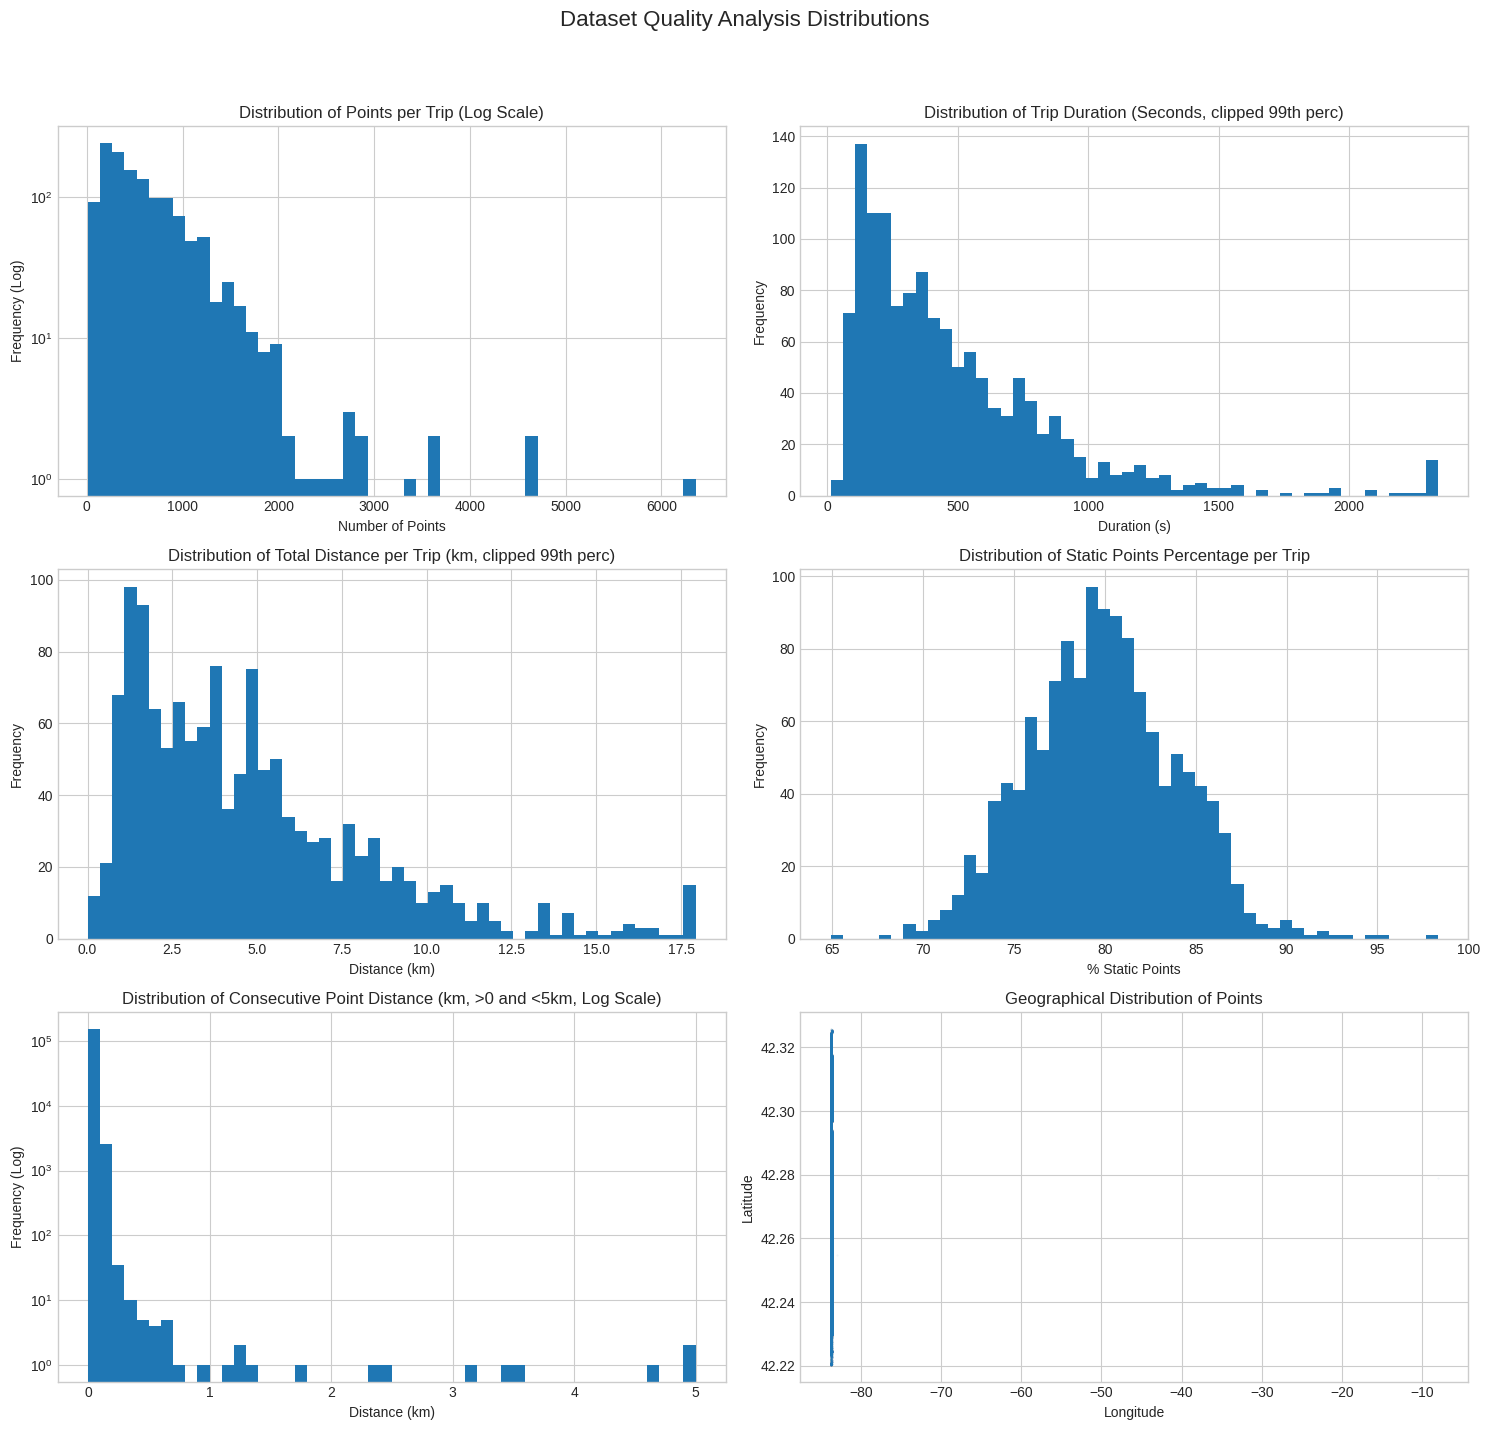


--- Overall Interpretation ---
Total number of trips analyzed: 1312
- High proportion of trips with excessive static points. Could indicate GPS issues or parked vehicles.
- Found very large distances (6008.42 km) between consecutive points, suggesting data errors or gaps.

Dataset has some potential issues. Careful filtering and cleaning are recommended before proceeding with RL.
Consider removing very short trips, trips with high static percentages, and potentially imputing missing values.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt

# Assuming ev_df is your loaded and potentially pre-processed DataFrame
# Make sure 'step_id' column exists if you added it earlier
if 'step_id' not in ev_df.columns:
    ev_df = ev_df.sort_values(by=['VehId', 'Trip', 'Timestamp(ms)']).reset_index(drop=True)
    ev_df['step_id'] = ev_df.index

print("\n--- Descriptive Statistics ---")
# Select potentially relevant columns for stats
desc_cols = ['Latitude[deg]', 'Longitude[deg]', 'Vehicle Speed[km/h]',
             'MAF[g/sec]', 'Engine RPM[RPM]', 'Absolute Load[%]', 'Speed Limit[km/h]']
# Filter out columns that might not exist
desc_cols = [col for col in desc_cols if col in ev_df.columns]
print(ev_df[desc_cols].describe())

print("\n--- Missing Value Analysis (Percentage) ---")
# Focus on columns critical for RL state/reward
critical_cols = ['Latitude[deg]', 'Longitude[deg]', 'Timestamp(ms)',
                 'Vehicle Speed[km/h]', 'MAF[g/sec]', 'Engine RPM[RPM]',
                 'Absolute Load[%]', 'Speed Limit[km/h]']
critical_cols = [col for col in critical_cols if col in ev_df.columns] # Ensure they exist
missing_perc = ev_df[critical_cols].isnull().mean() * 100
print(missing_perc)
if missing_perc.max() > 10: # Example threshold
    print("WARNING: Significant missing data found in critical columns. Consider imputation or data removal.")

# Define Haversine function for distance calculations
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees) using NumPy.
    Returns distance in kilometers.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c # Radius of earth in kilometers
    return km

# --- Trip Level Analysis ---
print("\n--- Trip Level Analysis ---")

# Calculate distance between consecutive points within each trip
lat_col = 'Matched Latitude[deg]' if 'Matched Latitude[deg]' in ev_df.columns else 'Latitude[deg]'
lon_col = 'Matched Longitude[deg]' if 'Matched Longitude[deg]' in ev_df.columns else 'Longitude[deg]'

# Ensure coordinates are float for calculations
ev_df[lat_col] = pd.to_numeric(ev_df[lat_col], errors='coerce')
ev_df[lon_col] = pd.to_numeric(ev_df[lon_col], errors='coerce')
# Drop rows where essential coords are now NaN after coercion
ev_df = ev_df.dropna(subset=[lat_col, lon_col, 'Timestamp(ms)'])

# Calculate consecutive distances
ev_df['prev_lat'] = ev_df.groupby(['VehId', 'Trip'])[lat_col].shift(1)
ev_df['prev_lon'] = ev_df.groupby(['VehId', 'Trip'])[lon_col].shift(1)
ev_df['consecutive_dist_km'] = haversine_np(ev_df['prev_lon'], ev_df['prev_lat'],
                                          ev_df[lon_col], ev_df[lat_col])
# Fill NaN for the first point of each trip
ev_df['consecutive_dist_km'].fillna(0, inplace=True)

# Calculate percentage of static points (consecutive points with same lat/lon)
ev_df['is_static'] = (ev_df[lat_col] == ev_df['prev_lat']) & (ev_df[lon_col] == ev_df['prev_lon'])

# Group by trip to get summary statistics
trip_groups = ev_df.groupby(['VehId', 'Trip'])

trip_summary = trip_groups.agg(
    num_points=('step_id', 'count'),
    start_time=('Timestamp(ms)', 'min'),
    end_time=('Timestamp(ms)', 'max'),
    start_lat=(lat_col, 'first'),
    start_lon=(lon_col, 'first'),
    end_lat=(lat_col, 'last'),
    end_lon=(lon_col, 'last'),
    total_dist_km=('consecutive_dist_km', 'sum'),
    perc_static_points=('is_static', lambda x: x.mean() * 100) # Calculate mean of boolean -> percentage
)

# Calculate trip duration in seconds
trip_summary['duration_s'] = (trip_summary['end_time'] - trip_summary['start_time']) / 1000.0

# Calculate straight-line distance from start to end
trip_summary['start_end_dist_km'] = haversine_np(trip_summary['start_lon'], trip_summary['start_lat'],
                                                trip_summary['end_lon'], trip_summary['end_lat'])

print("\n--- Trip Summary Statistics ---")
print(trip_summary.describe())

# --- Analyze Specific Issues ---

# 1. Short Trips
min_points_threshold = 10 # Set a threshold for minimum points needed
short_trips = trip_summary[trip_summary['num_points'] < min_points_threshold]
print(f"\nNumber of trips with fewer than {min_points_threshold} points: {len(short_trips)} ({len(short_trips)/len(trip_summary)*100:.2f}%)")
if len(short_trips) / len(trip_summary) > 0.1: # Example threshold
     print(f"WARNING: A significant portion of trips are very short (<{min_points_threshold} points).")

# 2. Static Trips (High percentage of non-moving points)
static_threshold = 50 # % threshold
static_trips = trip_summary[trip_summary['perc_static_points'] > static_threshold]
print(f"\nNumber of trips with > {static_threshold}% static points: {len(static_trips)} ({len(static_trips)/len(trip_summary)*100:.2f}%)")
if len(static_trips) / len(trip_summary) > 0.05: # Example threshold
     print("WARNING: A notable portion of trips have many static points.")

# 3. Trips with Zero/Negligible Travel Distance
zero_dist_threshold = 0.1 # km threshold
zero_dist_trips = trip_summary[trip_summary['total_dist_km'] < zero_dist_threshold]
print(f"\nNumber of trips with < {zero_dist_threshold} km total travel distance: {len(zero_dist_trips)} ({len(zero_dist_trips)/len(trip_summary)*100:.2f}%)")

# --- Visualize Distributions ---
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Dataset Quality Analysis Distributions', fontsize=16)

# Trip Length (Number of Points)
axes[0, 0].hist(trip_summary['num_points'], bins=50, log=True) # Use log scale if skewed
axes[0, 0].set_title('Distribution of Points per Trip (Log Scale)')
axes[0, 0].set_xlabel('Number of Points')
axes[0, 0].set_ylabel('Frequency (Log)')

# Trip Duration
axes[0, 1].hist(trip_summary['duration_s'].clip(upper=trip_summary['duration_s'].quantile(0.99)), bins=50) # Clip outliers for viz
axes[0, 1].set_title('Distribution of Trip Duration (Seconds, clipped 99th perc)')
axes[0, 1].set_xlabel('Duration (s)')
axes[0, 1].set_ylabel('Frequency')

# Total Distance Traveled per Trip
axes[1, 0].hist(trip_summary['total_dist_km'].clip(upper=trip_summary['total_dist_km'].quantile(0.99)), bins=50) # Clip outliers
axes[1, 0].set_title('Distribution of Total Distance per Trip (km, clipped 99th perc)')
axes[1, 0].set_xlabel('Distance (km)')
axes[1, 0].set_ylabel('Frequency')

# Percentage of Static Points per Trip
axes[1, 1].hist(trip_summary['perc_static_points'], bins=50)
axes[1, 1].set_title('Distribution of Static Points Percentage per Trip')
axes[1, 1].set_xlabel('% Static Points')
axes[1, 1].set_ylabel('Frequency')

# Consecutive Point Distance (excluding zero distances for better scale)
valid_consecutive_dist = ev_df[ev_df['consecutive_dist_km'] > 0]['consecutive_dist_km']
# Clip extreme outliers for visualization, e.g., distances > 5km between points likely errors
upper_clip_dist = 5 # km
clipped_dist = valid_consecutive_dist.clip(upper=upper_clip_dist)
axes[2, 0].hist(clipped_dist, bins=50, log=True)
axes[2, 0].set_title(f'Distribution of Consecutive Point Distance (km, >0 and <{upper_clip_dist}km, Log Scale)')
axes[2, 0].set_xlabel('Distance (km)')
axes[2, 0].set_ylabel('Frequency (Log)')
print(f"\nMax distance between consecutive points: {ev_df['consecutive_dist_km'].max():.2f} km")
large_jumps = ev_df[ev_df['consecutive_dist_km'] > upper_clip_dist]
print(f"Number of consecutive point distances > {upper_clip_dist} km: {len(large_jumps)} ({len(large_jumps)/len(ev_df)*100:.4f}%)")

# Geographical Spread
axes[2, 1].scatter(ev_df[lon_col], ev_df[lat_col], s=0.1, alpha=0.1) # Use sample if dataset is huge
axes[2, 1].set_title('Geographical Distribution of Points')
axes[2, 1].set_xlabel('Longitude')
axes[2, 1].set_ylabel('Latitude')
axes[2, 1].ticklabel_format(useOffset=False, style='plain') # Avoid scientific notation

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# --- Summary Interpretation ---
print("\n--- Overall Interpretation ---")
print(f"Total number of trips analyzed: {len(trip_summary)}")

# Combine findings into a recommendation
issue_count = 0
if len(short_trips) / len(trip_summary) > 0.1:
    print("- High proportion of very short trips found. These might be unusable for RL training requiring start/end points.")
    issue_count += 1
if len(static_trips) / len(trip_summary) > 0.05:
    print("- High proportion of trips with excessive static points. Could indicate GPS issues or parked vehicles.")
    issue_count += 1
if missing_perc.max() > 10:
     print("- Significant missing data in critical columns. Requires careful handling (imputation/removal).")
     issue_count += 1
if ev_df['consecutive_dist_km'].max() > 10: # Arbitrary threshold for clearly unrealistic jump
    print(f"- Found very large distances ({ev_df['consecutive_dist_km'].max():.2f} km) between consecutive points, suggesting data errors or gaps.")
    issue_count += 1

if issue_count == 0:
    print("\nDataset appears reasonably suitable. Minor cleaning might be needed, but no major red flags detected based on this analysis.")
elif issue_count <= 2:
    print("\nDataset has some potential issues. Careful filtering and cleaning are recommended before proceeding with RL.")
    print("Consider removing very short trips, trips with high static percentages, and potentially imputing missing values.")
else:
    print("\nDataset shows multiple significant quality issues (short trips, static points, missing data, large jumps).")
    print("It might be challenging to use this dataset directly for the RL task without substantial cleaning, filtering, or potentially acquiring better data.")
    print("Specifically address short trips, static points, and investigate large consecutive distances.")

Original DataFrame shape: (810767, 42)

--- Defining Bounding Box ---
Lat bounds: (42.2408, 42.3020)
Lon bounds: (-83.7712, -83.6840)
Shape after bounding box filter: (518048, 42) (63.90% points remaining)

--- Removing Redundant Static Points ---
Shape after removing redundant static points: (98443, 42) (19.00% points remaining from bounded df)

--- Filtering Short Trips Post-Cleaning ---
Shape after removing short trips post-cleaning: (98123, 42) (99.67% points remaining from cleaned df)
Total number of trips in final dataset: 1002

--- Analysis of Final Filtered Dataset ---

--- Final Trip Summary Statistics (Static Points Check) ---
count    1002.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: perc_static_points_final, dtype: float64


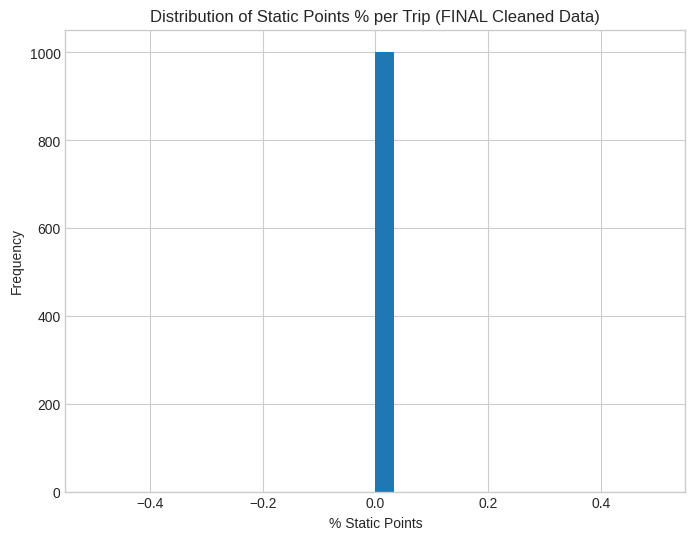


--- Final Data Ready ---
Final DataFrame shape for RL: (98123, 43)
Columns: ['DayNum', 'VehId', 'Trip', 'Timestamp(ms)', 'Latitude[deg]', 'Longitude[deg]', 'Vehicle Speed[km/h]', 'MAF[g/sec]', 'Engine RPM[RPM]', 'Absolute Load[%]', 'OAT[DegC]', 'Fuel Rate[L/hr]', 'Air Conditioning Power[kW]', 'Air Conditioning Power[Watts]', 'Heater Power[Watts]', 'HV Battery Current[A]', 'HV Battery SOC[%]', 'HV Battery Voltage[V]', 'Short Term Fuel Trim Bank 1[%]', 'Short Term Fuel Trim Bank 2[%]', 'Long Term Fuel Trim Bank 1[%]', 'Long Term Fuel Trim Bank 2[%]', 'Elevation Raw[m]', 'Elevation Smoothed[m]', 'Gradient', 'Energy_Consumption', 'Matchted Latitude[deg]', 'Matched Longitude[deg]', 'Match Type', 'Class of Speed Limit', 'Speed Limit[km/h]', 'Speed Limit with Direction[km/h]', 'Intersection', 'Bus Stops', 'Focus Points', 'source_file', 'Focus Points;', 'step_id', 'prev_lat', 'prev_lon', 'consecutive_dist_km', 'is_static', 'is_static_cleaned']


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume ev_df is the DataFrame after the initial loading and basic processing
# from the analysis script (including lat_col, lon_col definition)

print(f"Original DataFrame shape: {ev_df.shape}")

# --- 1. Define and Apply Bounding Box ---

# Define bounds using percentiles (e.g., 10th and 90th) to focus on the core area
lat_col = 'Matched Latitude[deg]' if 'Matched Latitude[deg]' in ev_df.columns else 'Latitude[deg]'
lon_col = 'Matched Longitude[deg]' if 'Matched Longitude[deg]' in ev_df.columns else 'Longitude[deg]'

lat_min_bound = ev_df[lat_col].quantile(0.10)
lat_max_bound = ev_df[lat_col].quantile(0.90)
lon_min_bound = ev_df[lon_col].quantile(0.10)
lon_max_bound = ev_df[lon_col].quantile(0.90)

print("\n--- Defining Bounding Box ---")
print(f"Lat bounds: ({lat_min_bound:.4f}, {lat_max_bound:.4f})")
print(f"Lon bounds: ({lon_min_bound:.4f}, {lon_max_bound:.4f})")

# Apply the filter
df_bounded = ev_df[
    (ev_df[lat_col] >= lat_min_bound) &
    (ev_df[lat_col] <= lat_max_bound) &
    (ev_df[lon_col] >= lon_min_bound) &
    (ev_df[lon_col] <= lon_max_bound)
].copy() # Use .copy() to avoid SettingWithCopyWarning later

print(f"Shape after bounding box filter: {df_bounded.shape} ({df_bounded.shape[0]/ev_df.shape[0]*100:.2f}% points remaining)")

if df_bounded.empty:
    raise ValueError("No data remaining after applying the bounding box filter. Adjust percentile values.")

# --- 2. Remove Redundant Static Points ---
print("\n--- Removing Redundant Static Points ---")

# Sort is crucial for identifying consecutive duplicates within trips
df_bounded = df_bounded.sort_values(by=['VehId', 'Trip', 'Timestamp(ms)']).reset_index(drop=True)

# Identify points that are identical to the *previous* point based on key columns
# We check VehId and Trip to ensure we only compare within the same trip
duplicates_mask = df_bounded.duplicated(subset=['VehId', 'Trip', lat_col, lon_col], keep='first')

# Keep only the points that are NOT duplicates (i.e., keep the first occurrence)
df_cleaned = df_bounded[~duplicates_mask].copy()

print(f"Shape after removing redundant static points: {df_cleaned.shape} ({df_cleaned.shape[0]/df_bounded.shape[0]*100:.2f}% points remaining from bounded df)")

if df_cleaned.empty:
    raise ValueError("No data remaining after removing static points.")

# --- 3. Filter Short Trips (Post-Cleaning) ---
print("\n--- Filtering Short Trips Post-Cleaning ---")

min_points_threshold_post = 10 # Minimum points required after cleaning

# Group by trip and count remaining points
trip_point_counts = df_cleaned.groupby(['VehId', 'Trip']).size()

# Identify trips that meet the threshold
valid_trips = trip_point_counts[trip_point_counts >= min_points_threshold_post].index

# Filter the cleaned DataFrame to keep only valid trips
# Use isin with the multi-index
df_final = df_cleaned[df_cleaned.set_index(['VehId', 'Trip']).index.isin(valid_trips)].reset_index(drop=True)

# Optional: Assign a new step_id if needed for the environment
df_final['step_id'] = df_final.index

print(f"Shape after removing short trips post-cleaning: {df_final.shape} ({df_final.shape[0]/df_cleaned.shape[0]*100:.2f}% points remaining from cleaned df)")
final_trips_count = df_final[['VehId', 'Trip']].drop_duplicates().shape[0]
print(f"Total number of trips in final dataset: {final_trips_count}")

if df_final.empty:
    raise ValueError("No data remaining after filtering short trips post-cleaning.")

# --- 4. Re-run Analysis on the Final Dataset (Optional but Recommended) ---
print("\n--- Analysis of Final Filtered Dataset ---")

# (You can copy/paste the analysis code from the previous response here,
# running it on `df_final` instead of `ev_df`)

# Example: Recalculate static points percentage on the cleaned data
df_final['prev_lat'] = df_final.groupby(['VehId', 'Trip'])[lat_col].shift(1)
df_final['prev_lon'] = df_final.groupby(['VehId', 'Trip'])[lon_col].shift(1)
df_final['is_static_cleaned'] = (df_final[lat_col] == df_final['prev_lat']) & (df_final[lon_col] == df_final['prev_lon'])

trip_groups_final = df_final.groupby(['VehId', 'Trip'])
trip_summary_final = trip_groups_final.agg(
    num_points_final=('step_id', 'count'), # Use a unique name like step_id or another column
    perc_static_points_final=('is_static_cleaned', lambda x: x.mean() * 100)
)

print("\n--- Final Trip Summary Statistics (Static Points Check) ---")
print(trip_summary_final['perc_static_points_final'].describe())

plt.figure(figsize=(8, 6))
plt.hist(trip_summary_final['perc_static_points_final'], bins=30)
plt.title('Distribution of Static Points % per Trip (FINAL Cleaned Data)')
plt.xlabel('% Static Points')
plt.ylabel('Frequency')
plt.show()

print("\n--- Final Data Ready ---")
print(f"Final DataFrame shape for RL: {df_final.shape}")
print(f"Columns: {df_final.columns.tolist()}")

# Now you can use `df_final` to initialize your RouteEnv
# Example: env = RouteEnv(df_final, ...)

In [14]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.017):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight_mu = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))
        self.reset_parameters(sigma_init)
        self.reset_noise()

    def reset_parameters(self, sigma_init):
        mu_range = 1. / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(sigma_init)
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(sigma_init)

    def reset_noise(self):
        eps_in = torch.randn(self.in_features)
        eps_out = torch.randn(self.out_features)
        f = lambda x: torch.sign(x) * torch.sqrt(x.abs())
        self.weight_epsilon.copy_(f(eps_out).outer(f(eps_in)))
        self.bias_epsilon.copy_(f(eps_out))

    def forward(self, x):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(x, weight, bias)

# 2) Dueling DQN with Noisy Layers
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        # Value Stream
        self.value = nn.Sequential(
            NoisyLinear(128, 128),
            nn.ReLU(),
            NoisyLinear(128, 1)
        )
        # Advantage Stream
        self.advantage = nn.Sequential(
            NoisyLinear(128, 128),
            nn.ReLU(),
            NoisyLinear(128, action_dim)
        )

    def forward(self, x):
        x = self.feature(x)
        val = self.value(x)
        adv = self.advantage(x)
        # Q = V + (A - mean(A))
        return val + adv - adv.mean(dim=1, keepdim=True)

In [17]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.pos = 0
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)

    def add(self, state, action, reward, next_state, done):
        max_prio = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        probs = prios ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        batch = list(zip(*samples))
        states = torch.FloatTensor(np.array(batch[0]))
        actions = torch.LongTensor(batch[1])
        rewards = torch.FloatTensor(batch[2])
        next_states = torch.FloatTensor(np.array(batch[3]))
        dones = torch.FloatTensor(batch[4])
        return states, actions, rewards, next_states, dones, indices, torch.FloatTensor(weights)

    def update_priorities(self, indices, losses, offset=1e-6):
        for idx, loss in zip(indices, losses):
            self.priorities[idx] = abs(loss.item()) + offset

# 4) N‑Step Transition Buffer
class NStepBuffer:
    def __init__(self, n, gamma):
        self.n = n
        self.gamma = gamma
        self.buffer = deque()

    def append(self, transition):  # (s,a,r,s',done)
        self.buffer.append(transition)
        if len(self.buffer) < self.n:
            return None
        # compute n‑step return
        R, d = 0.0, False
        for i, (_, _, r, _, done) in enumerate(self.buffer):
            R += (self.gamma**i) * r
            if done:
                d = True
                break
        s0, a0 = self.buffer[0][0], self.buffer[0][1]
        s_n, done_n = self.buffer[-1][3], self.buffer[-1][4]
        self.buffer.popleft()
        return (s0, a0, R, s_n, done_n)

# 5) Modified Agent with Soft Updates
class RainbowAgent:
    def __init__(self, state_dim, action_dim, lr=1e-4, gamma=0.99,
                 buffer_size=50000, batch_size=64, n_step=3, tau=0.005):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau
        # networks
        self.online = DuelingDQN(state_dim, action_dim).to(self.device)
        self.target = DuelingDQN(state_dim, action_dim).to(self.device)
        self.target.load_state_dict(self.online.state_dict())
        # replay
        self.memory = PrioritizedReplayBuffer(buffer_size)
        self.nstep = NStepBuffer(n_step, gamma)
        # optimizer
        self.optimizer = torch.optim.AdamW(self.online.parameters(), lr=lr)
        # exploration
        self.steps = 0

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        self.online.eval()
        with torch.no_grad():
            q = self.online(state)
        self.online.train()
        return q.argmax(1).item()

    def reset_noise(self):
        # propagate reset through any NoisyLinear layers
        for net in (self.online, self.target):
            for m in net.modules():
                if hasattr(m, "reset_noise"):
                    m.reset_noise()

    def store(self, s, a, r, s2, done):
        # add n-step then single-step
        transition = (s, a, r, s2, done)
        batch = self.nstep.append(transition)
        if batch:
            self.memory.add(*batch)

    def update(self, beta=0.4):
        if len(self.memory.buffer) < self.batch_size:
            return
        # sample
        states, actions, rewards, next_states, dones, idxs, weights = self.memory.sample(self.batch_size, beta)
        states, actions, rewards, next_states, dones, weights = [x.to(self.device) for x in (states, actions, rewards, next_states, dones, weights)]
        # current Q
        q_pred = self.online(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        # double DQN target
        next_actions = self.online(next_states).argmax(1)
        q_next = self.target(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        q_target = rewards + (self.gamma**self.nstep.n) * (1 - dones) * q_next
        # loss
        td_error = q_pred - q_target.detach()
        loss = (weights * td_error.pow(2)).mean()
        # optimize
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.online.parameters(), max_norm=1.0)
        self.optimizer.step()
        # update priorities
        self.memory.update_priorities(idxs, td_error.abs().cpu())
        # soft update
        for p, t in zip(self.online.parameters(), self.target.parameters()):
            t.data.copy_(self.tau * p.data + (1 - self.tau) * t.data)
        return loss.detach().cpu().item()

In [22]:
import pickle
import os

def save_checkpoint(path, agent, optimizer, replay_buffer, nstep_buffer, episode):
    """Save everything needed to resume training later."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    checkpoint = {
        'episode':             episode,
        'online_state_dict':   agent.online.state_dict(),
        'target_state_dict':   agent.target.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'replay_buffer':       replay_buffer.buffer,     # list of transitions
        'priorities':          replay_buffer.priorities, # numpy array
        'nstep_buffer':        list(nstep_buffer.buffer),
        'rng_state_cpu':       torch.get_rng_state(),
        'rng_state_cuda':      torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
    }
    # Use torch.save for all PyTorch tensors + lists
    torch.save(checkpoint, path)
    print(f"📦 Checkpoint saved to {path}")

def load_checkpoint(path, agent, optimizer, replay_buffer, nstep_buffer):
    """Load agent + optimizer + buffers + episode count. Returns start_episode."""
    checkpoint = torch.load(path, map_location=agent.device)
    agent.online.load_state_dict(checkpoint['online_state_dict'])
    agent.target.load_state_dict(checkpoint['target_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # restore replay buffer
    replay_buffer.buffer = checkpoint['replay_buffer']
    replay_buffer.priorities = checkpoint['priorities']
    replay_buffer.pos = len(replay_buffer.buffer) % replay_buffer.capacity

    # restore n-step buffer
    nstep_buffer.buffer = pickle.deque(checkpoint['nstep_buffer'], maxlen=nstep_buffer.n)

    # restore RNG states
    torch.set_rng_state(checkpoint['rng_state_cpu'])
    if checkpoint['rng_state_cuda']:
        torch.cuda.set_rng_state_all(checkpoint['rng_state_cuda'])

    start_episode = checkpoint['episode'] + 1
    print(f"🔄 Loaded checkpoint from {path}, resuming at episode {start_episode}")
    return start_episode

# === Integration into your loop ===
checkpoint_path = "checkpoints/rainbow_route.ckpt"
start_ep = 1

# If a checkpoint already exists, load it:
if os.path.exists(checkpoint_path):
    start_ep = load_checkpoint(
        checkpoint_path,
        agent,
        agent.optimizer,
        agent.memory,
        agent.nstep
    )

In [ ]:

env = RouteEnv(df_final, k_neighbors=3, max_steps=1500)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
#agent = DQNAgent(state_dim, action_dim, lr=5e-4, batch_size=128, epsilon_decay=0.999, replay_buffer_capacity=50000) # Smaller buffer if memory is limited
agent = RainbowAgent(state_dim, action_dim, lr=1e-4, gamma=0.99, buffer_size=50000, batch_size=64, n_step=3, tau=0.005)


num_episodes = 1000 # Adjust as needed
target_update_freq = 10 # Update target network every N episodes
print_freq = 20

episode_rewards = []
episode_losses = []

print(f"Starting training for {num_episodes} episodes...")
print(f"Device: {agent.device}")

for episode in range(1, num_episodes+1):
    # Reset env and noise for NoisyNets
    state, info = env.reset()
    agent.reset_noise()

    total_reward = 0.0
    losses       = []
    steps        = 0
    done         = False

    # Linearly anneal β in PER from 0.4→1.0 over all episodes
    beta = min(1.0, 0.4 + (episode / num_episodes) * 0.6)

    while not done:
        # 1) select & execute
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # 2) store & learn
        agent.store(state, action, reward, next_state, done)
        loss = agent.update(beta)
        if loss is not None:
            losses.append(loss.item())

        state = next_state
        total_reward += reward
        steps += 1

    # record
    episode_rewards.append(total_reward)
    avg_loss = float(np.mean(losses)) if losses else 0.0
    episode_losses.append(avg_loss)

    if episode % 50 == 0 or episode == num_episodes:
        save_checkpoint(
            checkpoint_path,
            agent,
            agent.optimizer,
            agent.memory,
            agent.nstep,
            episode
        )
    
    # logging
    if episode % print_freq == 0 or episode == num_episodes:
        recent_avg = np.mean(episode_rewards[-print_freq:])
        print(
            f"Ep {episode:4d}/{num_episodes} "
            f"| Steps: {steps:4d} "
            f"| Rwd: {total_reward:7.2f} "
            f"| RecentAvg: {recent_avg:7.2f} "
            f"| Loss: {avg_loss:.4f} β={beta:.2f}"
        )

print("✔️ Training finished.")

# Save the trained agent
agent.save("dqn_route_agent.pth")

KDTree built for environment using 98123 points.
Normalization bounds recalculated using final data.
Starting training for 1000 episodes...
Device: cuda
Ep   20/1000 | Steps: 1500 | Rwd: -1620.75 | RecentAvg: -161.26 | Loss: 0.0000 β=0.41
Ep   40/1000 | Steps: 1500 | Rwd: -1619.62 | RecentAvg: 2088.45 | Loss: 0.0000 β=0.42
📦 Checkpoint saved to checkpoints/rainbow_route.ckpt
Ep   60/1000 | Steps: 1500 | Rwd: -1621.98 | RecentAvg: -190.98 | Loss: 0.0000 β=0.44
Ep   80/1000 | Steps: 1500 | Rwd: -1619.15 | RecentAvg: 1326.55 | Loss: 0.0000 β=0.45
📦 Checkpoint saved to checkpoints/rainbow_route.ckpt
Ep  100/1000 | Steps: 1500 | Rwd: 19356.59 | RecentAvg: 4973.34 | Loss: 0.0000 β=0.46
Ep  120/1000 | Steps: 1500 | Rwd: -1615.74 | RecentAvg: 8863.00 | Loss: 0.0000 β=0.47
Ep  140/1000 | Steps: 1500 | Rwd: -1611.89 | RecentAvg: 5536.00 | Loss: 0.0000 β=0.48
📦 Checkpoint saved to checkpoints/rainbow_route.ckpt
Ep  160/1000 | Steps: 1500 | Rwd: -1616.57 | RecentAvg: 5338.20 | Loss: 0.0000 β=0.50


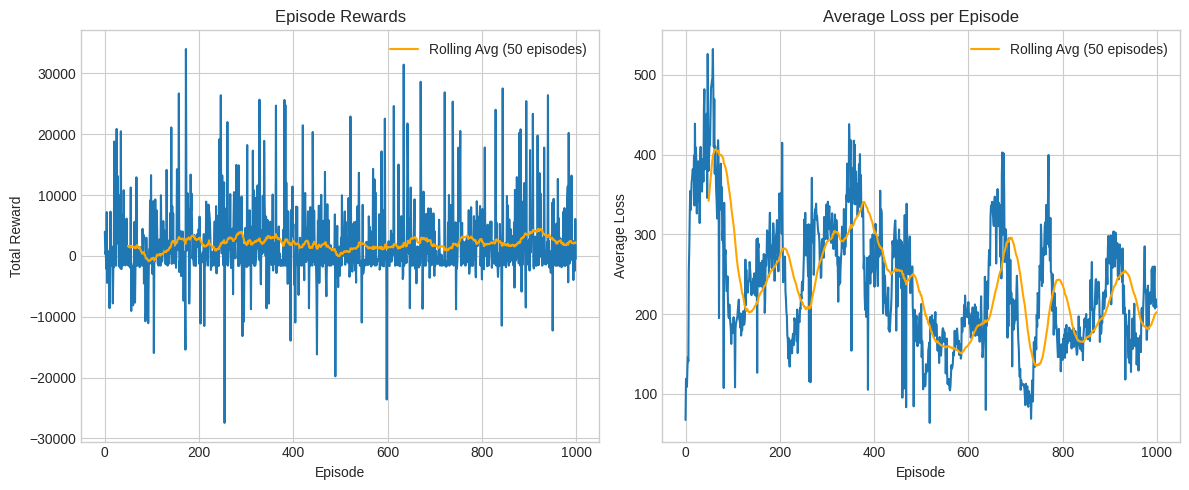

In [12]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
# Add a rolling average
rolling_avg = pd.Series(episode_rewards).rolling(window=max(1, num_episodes // 20)).mean()
plt.plot(rolling_avg, label=f'Rolling Avg ({max(1, num_episodes // 20)} episodes)', color='orange')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(episode_losses)
plt.title('Average Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Average Loss')
# Add a rolling average
rolling_avg_loss = pd.Series(episode_losses).rolling(window=max(1, num_episodes // 20)).mean()
plt.plot(rolling_avg_loss, label=f'Rolling Avg ({max(1, num_episodes // 20)} episodes)', color='orange')
plt.legend()

plt.tight_layout()
plt.show()



--- Evaluating Agent ---
Eval Episode 1/20 | Steps: 1500 | Reward: -468.29 | Reached Goal: False
Eval Episode 2/20 | Steps: 1500 | Reward: 36560.61 | Reached Goal: False
Eval Episode 3/20 | Steps: 1500 | Reward: 26441.14 | Reached Goal: False
Eval Episode 4/20 | Steps: 1500 | Reward: -1616.92 | Reached Goal: False
Eval Episode 5/20 | Steps: 1500 | Reward: 1386.47 | Reached Goal: False
Eval Episode 6/20 | Steps: 1500 | Reward: 10241.34 | Reached Goal: False
Eval Episode 7/20 | Steps: 1500 | Reward: 14888.24 | Reached Goal: False
Eval Episode 8/20 | Steps: 1500 | Reward: -1612.51 | Reached Goal: False
Eval Episode 9/20 | Steps: 1500 | Reward: -1612.46 | Reached Goal: False
Eval Episode 10/20 | Steps: 1500 | Reward: -1618.85 | Reached Goal: False
Eval Episode 11/20 | Steps: 1500 | Reward: 17873.71 | Reached Goal: False
Eval Episode 12/20 | Steps: 1500 | Reward: -1610.72 | Reached Goal: False
Eval Episode 13/20 | Steps: 1500 | Reward: -1554.59 | Reached Goal: False
Eval Episode 14/20 | St

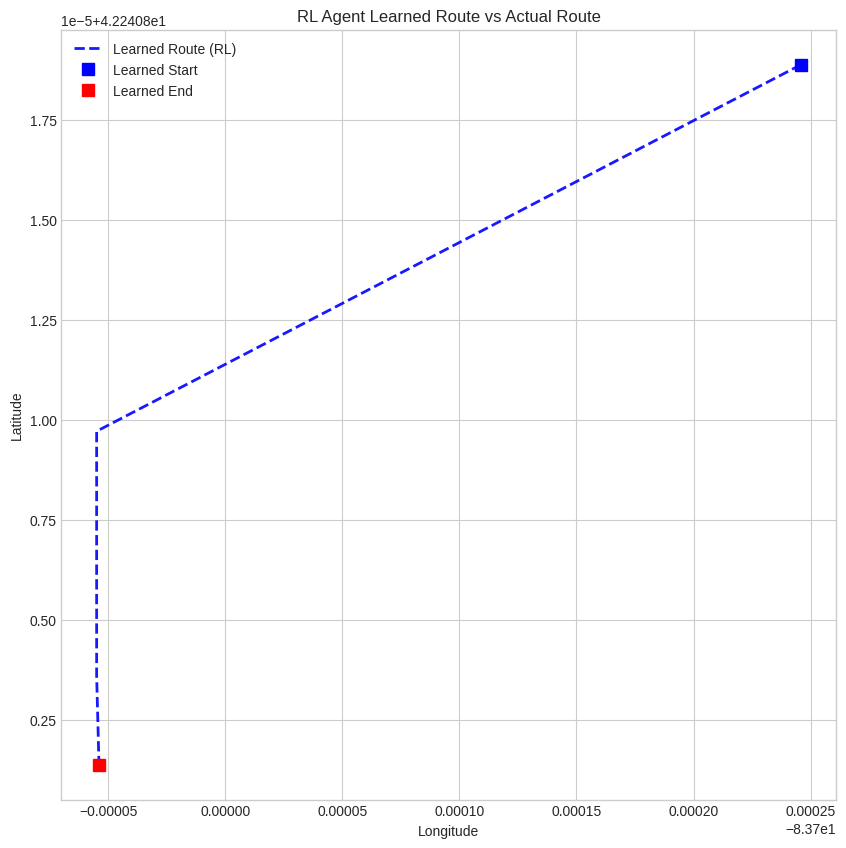

In [13]:


def evaluate_agent(env, agent, num_episodes=10):
    agent.epsilon = 0 # Set epsilon to 0 for deterministic evaluation
    all_routes = []
    all_rewards = []

    print("\n--- Evaluating Agent ---")
    for episode in range(num_episodes):
        state, info = env.reset()
        episode_route = [info['start_coords']]
        total_reward = 0
        terminated = False
        truncated = False
        steps = 0

        while not terminated and not truncated:
            action = agent.select_action(state) # Use learned policy
            next_state, reward, terminated, truncated, info = env.step(action)
            state = next_state
            total_reward += reward
            if 'current_coords' in info:
                 # Denormalize coordinates for plotting if needed, or keep original from info
                 episode_route.append(info['current_coords'])
            steps += 1

        all_routes.append(episode_route)
        all_rewards.append(total_reward)
        print(f"Eval Episode {episode+1}/{num_episodes} | Steps: {steps} | Reward: {total_reward:.2f} | Reached Goal: {terminated}")

    print(f"Average Evaluation Reward: {np.mean(all_rewards):.2f}")
    return all_routes, all_rewards

# Load agent if needed
# agent = DQNAgent(state_dim, action_dim)
# agent.load("dqn_route_agent.pth")

eval_routes, eval_rewards = evaluate_agent(env, agent, num_episodes=20)


def visualize_rl_vs_actual(df, learned_route, actual_start_coords, actual_end_coords):
    """ Visualizes one learned route against the potential actual route """
    # Find the actual trip data corresponding to the start/end points
    actual_trip = df[
        (np.isclose(df[lat_col], actual_start_coords[0])) &
        (np.isclose(df[lon_col], actual_start_coords[1])) &
        (np.isclose(df[lat_col].shift(-1 * (df.groupby(['VehId', 'Trip']).cumcount().max())), actual_end_coords[0])) & # A bit tricky way to find end
        (np.isclose(df[lon_col].shift(-1 * (df.groupby(['VehId', 'Trip']).cumcount().max())), actual_end_coords[1]))
    ].groupby(['VehId', 'Trip']).first().reset_index() # Get the first matching trip if multiple

    # Find the full actual path if a match was found
    actual_lats, actual_lngs = [], []
    if not actual_trip.empty:
         veh_id = actual_trip['VehId'].iloc[0]
         trip_id = actual_trip['Trip'].iloc[0]
         actual_path_df = df[(df['VehId'] == veh_id) & (df['Trip'] == trip_id)].sort_values('Timestamp(ms)')
         actual_lats = actual_path_df[lat_col].tolist()
         actual_lngs = actual_path_df[lon_col].tolist()


    learned_lats = [p[0] for p in learned_route]
    learned_lngs = [p[1] for p in learned_route]

    plt.figure(figsize=(10, 10))

    if actual_lats:
        plt.plot(actual_lngs, actual_lats, 'g-', linewidth=2, alpha=0.7, label='Actual Route')
        plt.plot(actual_lngs[0], actual_lats[0], 'go', markersize=10, label='Actual Start')
        plt.plot(actual_lngs[-1], actual_lats[-1], 'ro', markersize=10, label='Actual End')

    # Plot learned route
    plt.plot(learned_lngs, learned_lats, 'b--', linewidth=2, alpha=0.9, label='Learned Route (RL)')
    if learned_lats:
         plt.plot(learned_lngs[0], learned_lats[0], 'bs', markersize=8, label='Learned Start')
         plt.plot(learned_lngs[-1], learned_lats[-1], 'rs', markersize=8, label='Learned End')


    plt.title('RL Agent Learned Route vs Actual Route')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)

    try:
        all_lats = actual_lats + learned_lats
        all_lngs = actual_lngs + learned_lngs
        if all_lats: # Ensure there are coordinates to plot
            margin = 0.01
            north, south = max(all_lats) + margin, min(all_lats) - margin
            east, west = max(all_lngs) + margin, min(all_lngs) - margin
            # Check for valid bounding box
            if north > south and east > west:
                G = ox.graph.graph_from_bbox(north=north, south=south, east=east, west=west, network_type='drive', simplify=True)
                fig_map, ax_map = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5, bgcolor='w')

                if actual_lats:
                    ax_map.plot(actual_lngs, actual_lats, 'g-', linewidth=2, alpha=0.7, label='Actual Route')
                    ax_map.plot(actual_lngs[0], actual_lats[0], 'go', markersize=10)
                    ax_map.plot(actual_lngs[-1], actual_lats[-1], 'ro', markersize=10)
                ax_map.plot(learned_lngs, learned_lats, 'b--', linewidth=2, alpha=0.9, label='Learned Route (RL)')
                if learned_lats:
                    ax_map.plot(learned_lngs[0], learned_lats[0], 'bs', markersize=8)
                    ax_map.plot(learned_lngs[-1], learned_lats[-1], 'rs', markersize=8)

                ax_map.set_title('RL Agent Learned Route vs Actual Route (on Map)')
                ax_map.legend()
                plt.show() # Show the map plot separately
            else:
                print("Warning: Invalid bounding box for OSMnx plot.")
                plt.show() # Show the simple plot
        else:
             plt.show() # Show the simple plot if no coordinates found

    except Exception as e:
        print(f"Could not plot on OSMnx map: {e}")
        plt.show() # Fallback to simple plot

# Visualize one of the evaluated routes
if eval_routes:
    # Find the corresponding start/end to look up the actual route
    # This relies on how the environment reset stores info
    state, info = env.reset() # Reset again to get a sample start/end
    # Find the actual route based on the start/end used in evaluation if possible
    # This lookup part is tricky and might need refinement based on how you store eval start/end points
    # For now, just using the last generated start/end from env.reset() as an example
    visualize_rl_vs_actual(ev_df, eval_routes[0], info['start_coords'], info['dest_coords'])
else:
    print("No evaluation routes to visualize.")